In [14]:
from bda.utils import plot_beta_binomial, summarize_beta_binomial, quantiles_beta, proba_beta, odds, mcmc_stan, mcmc_hist, mcmc_dens, mcmc_trace, mcmc_acf, rhat, neff_ratio, quantiles_mcmc, proba_mcmc, mcmc_combine_chains, mcmc_summarize
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MoMA (Museum of Modern Art) Beispiel

Folgendes Modell wird verwendet:

$$
\begin{array}{rl}
Y \mid \pi &\sim \mathrm{Binomial}(100, \pi), \\[6pt]
\pi &\sim \mathrm{Beta}(4, 6), \\[6pt]
\Rightarrow &\pi \mid (Y = 14) \sim \mathrm{Beta}(18, 92).
\end{array}
$$


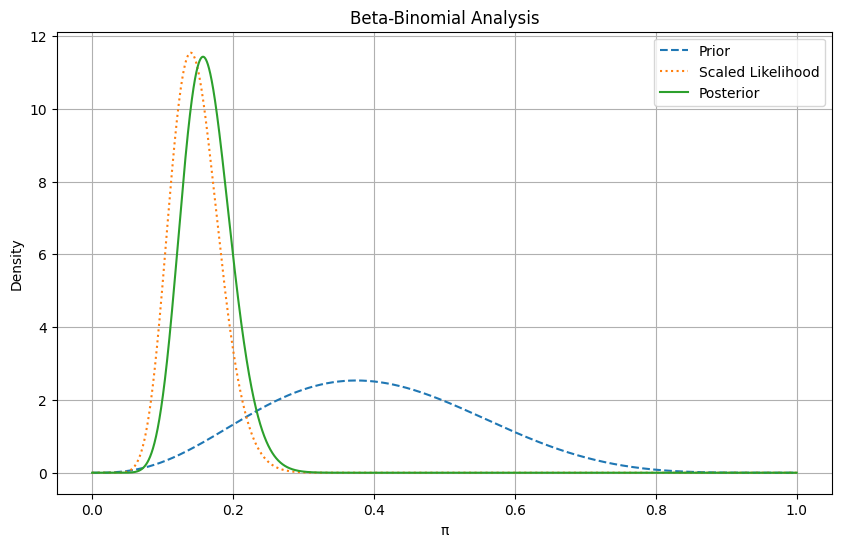

,alpha,beta,mean,mode,var,sd
model,,,,,,
prior,4,6,0.400000,0.375000,0.021818,0.147710
posterior,18,92,0.163636,0.157407,0.001233,0.035114


In [15]:
plot_beta_binomial(4, 6, 100, 14)
summarize_beta_binomial(4, 6, 100, 14)

## 8.1 Posterior estimation

95% Credible Intervall:

In [16]:
quantiles_beta(18, 92, [0.025, 0.975])

array([0.10090844, 0.23792856])

50% Credible Intervall:

In [17]:
quantiles_beta(18, 92, [0.25, 0.75])

array([0.1388414 , 0.18621971])

## 8.2 Posterior hypothesis testing

### 8.2.1 One-sided tests

$$
P(\pi < 0.2 \mid Y = 14) = \int_0^{0.2} f(\pi \mid Y = 14) \, d\pi.
$$


In [18]:
proba_beta(18, 92, l_than=0.2)

(0.848985555953253, None, None)

Und nun im Hypothesis-Testing Framework:

$$
\begin{aligned}
H_0 &: \pi \geq 0.2, \\
H_a &: \pi < 0.2.
\end{aligned}
$$

In [19]:
proba_beta(18, 92, l_than=0.2, h_than=0.2)

(0.848985555953253, None, 0.15101444404674702)

Aus dem ganzen können nun die odds berechnet werden:

In [20]:
odds(proba_beta(18, 92, l_than=0.2)[0])

5.621883133844116

Es ist somit also 5.6 mal wahrscheinlicher, dass die wahrscheinlichkeit < 0.2 ist.

### 8.2.2 Two-sided tests

Nun möchten wir testen, ob $\pi$ genau 0.3 ist:

$$
\begin{aligned}
H_0 &: \pi = 0.3, \\
H_a &: \pi \neq 0.3.
\end{aligned}
$$

So lässt sich das ganze allerdings nicht rechnen, da Beta kontinuierlich ist.

Deshalb muss von einem Intervall ausgegangen werden:

$$
\begin{aligned}
H_0 &: \pi \in (0.25, 0.35), \\
H_a &: \pi \notin (0.25, 0.35).
\end{aligned}
$$

In [21]:
proba_beta(18, 92, between=[0.25, 0.35])

(None, 0.012500770337944167, None)

## 8.3 Posterior prediction

Nun möchten wir vorhersagen, wieviele hits wir bekommen, wenn wir 20 neue samples sammeln würden.  

Leider ist es nun nicht so einfach, dass wir den wert mit der grössten plausibilität nehmen würden:

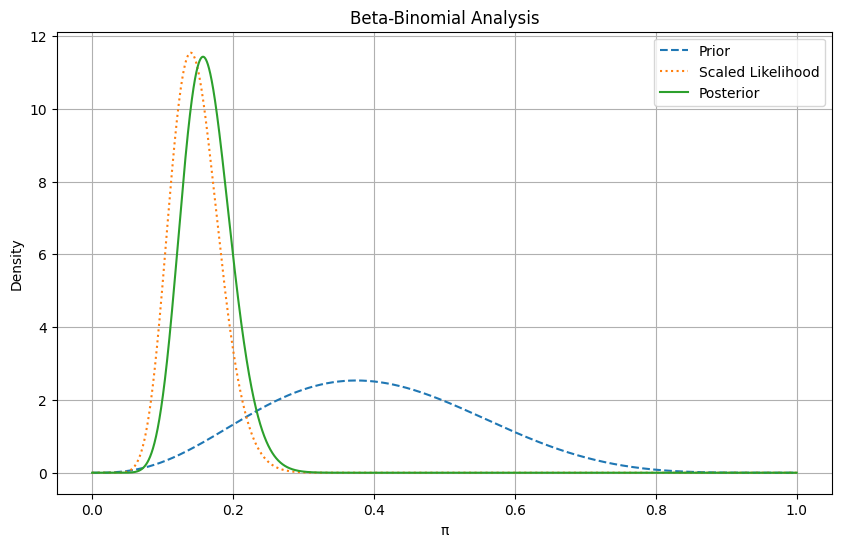

,alpha,beta,mean,mode,var,sd
model,,,,,,
prior,4,6,0.400000,0.375000,0.021818,0.147710
posterior,18,92,0.163636,0.157407,0.001233,0.035114


In [22]:
plot_beta_binomial(4, 6, 100, 14)
summarize_beta_binomial(4, 6, 100, 14)

Denn dann könnte man meinen, dass ca 20*0.157407 ~ 3 hits auf 20 Samples passieren würde. Aber wir vergessen, dass es einmal noch Variabilität in den Daten gibt und auch, dass $\pi$ selbst variiert.

Dies lässt sich in folgendes aufteilen:
- Sampling variability
- Posterior variabilitys

Die *Sampling variability* lässt sich mittels Binomialverteilung darstellen. Für $\pi = 0.1$ ist das folgendes:

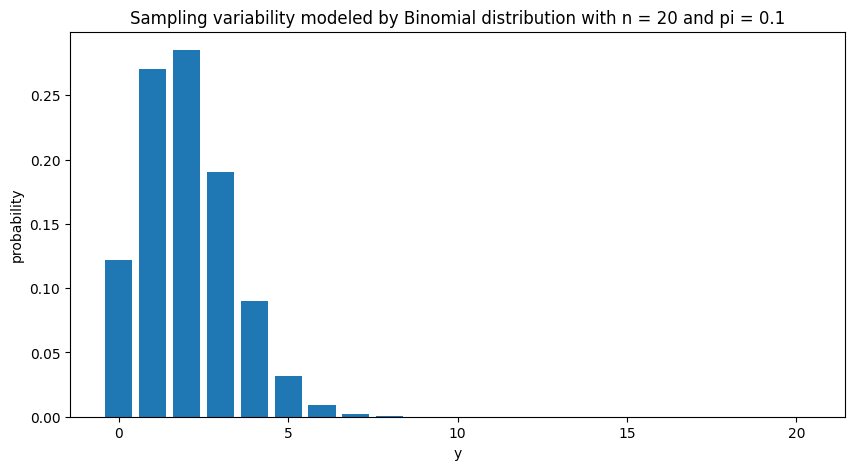

In [23]:
y = np.arange(0, 21)
proba = stats.binom(n=20, p=0.1).pmf(y)

plt.figure(figsize=(10, 5))
plt.bar(y, proba)
plt.title("Sampling variability modeled by Binomial distribution with n = 20 and pi = 0.1")
plt.xlabel("y")
plt.ylabel("probability")
plt.show()

Dies modeliert die Variabilität der Anzahl hits bei n=20 und pi von 0.1.  
Die Posterior variability wird gerade von der Posterior distribution modeliert. Somit müssen diese beiden nur noch verheiratet werden:

$$f(y^{'}|\pi)*f(\pi|y=14)$$

wobei $f(\pi|y=14)$ das Posterior Modell ist und $y^{'}$ die zu vorhersagende Variabel.


Nun muss das ganze noch marginalisiert werden, bzw $y^{'}$ über alle $\pi$'s betrachtet werden:

$$
f(y' \mid y) = \int f(y' \mid \pi) f(\pi \mid y) \, d\pi.
$$

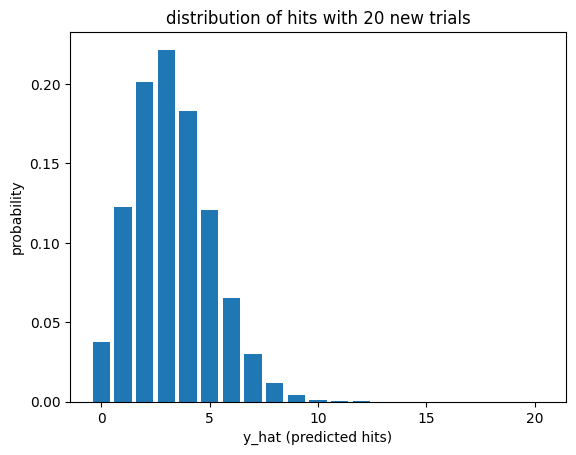

In [24]:
y = np.arange(0, 21)
pi = np.linspace(0, 1, 1000)

posterior_proba = stats.beta(18, 92).pdf(pi)

posterior_predictive_proba = []
for y_ in y:
    likelihood = stats.binom.pmf(n=20, k=y_, p=pi)

    marginalized = np.trapz(likelihood * posterior_proba, pi)

    posterior_predictive_proba.append(marginalized)

posterior_predictive_proba = np.array(posterior_predictive_proba)

plt.bar(y, posterior_predictive_proba)
plt.title("distribution of hits with 20 new trials")
plt.xlabel("y_hat (predicted hits)")
plt.ylabel("probability")
plt.show()

Nun ist die Wahrscheinlichkeit unter den 20 neuen datenpunkten k hits zu erzielen als wahrscheinlichkeit dargestellt. Nun kann damit weitergerechnet werden. Wie z.B:

- Was ist die Wahrscheinlichkeit, dass mindestens 5 hits erzielt werden?

In [25]:
posterior_predictive_proba[5:].sum()

0.23298739435887847

Somit ist die Wahrscheinlichkeit ca 23.3%, dass mindestens 5 hits erzielt werden.

Nun kann man noch den Erwartungswert berechnen:

In [26]:
np.sum(posterior_predictive_proba*np.arange(0, 21))

3.2727272727272743

# 8.4 Posterior analysis with MCMC

## 8.4.1 Posterior simulation

Nun simulieren wir das ganze mittels MCMC:

In [27]:
model = """
    data{
        int<lower = 0, upper = 100> Y;
    }
    
    parameters{
        real<lower = 0, upper = 1> pi;
    }

    model{
        Y ~ binomial(100, pi);
        pi ~ beta(4, 6);
    }
"""

data = {
    "Y": 14
}

mcmc_results = mcmc_stan(model, data)

mcmc_results

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_3u9s3hpl/model_ngnyoc3p.stan', line 11, column 21: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accord

,chain_0,chain_1,chain_2,chain_3,sample_nr,var_name,is_warmup
0,0.180474,0.187892,0.116754,0.195293,0,pi,False
1,0.172551,0.202810,0.109182,0.177510,1,pi,False
2,0.150554,0.146186,0.109669,0.177510,2,pi,False
3,0.150554,0.162388,0.107932,0.177510,3,pi,False
4,0.152793,0.145864,0.154428,0.201641,4,pi,False
...,...,...,...,...,...,...,...
9995,0.177844,0.160027,0.147109,0.179500,9995,pi,False
9996,0.191946,0.167597,0.150311,0.194791,9996,pi,False
9997,0.175070,0.141471,0.171534,0.153965,9997,pi,False
9998,0.203922,0.179565,0.197569,0.194295,9998,pi,False


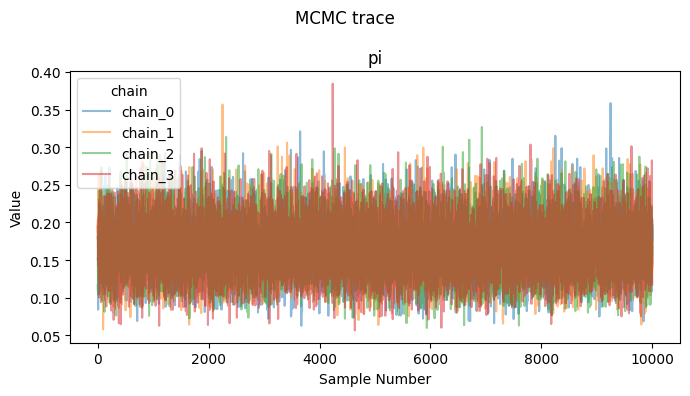

In [28]:
mcmc_trace(mcmc_results)

Trace sieht soweit gut aus

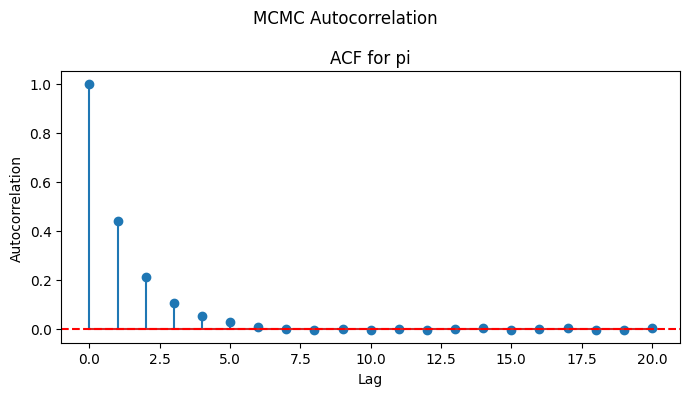

In [29]:
mcmc_acf(mcmc_results)

Korrelation nimmt relativ schnell ab -> auch gut

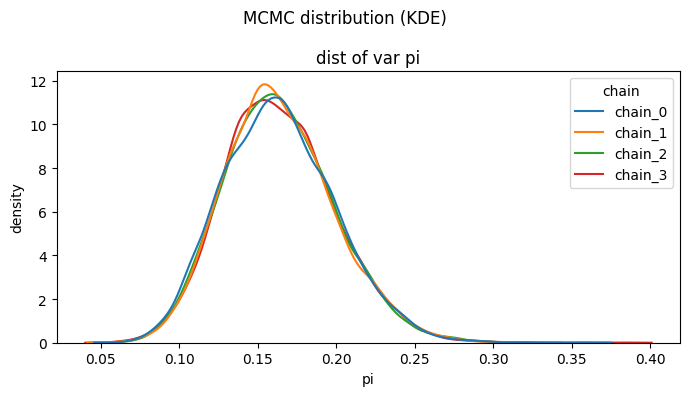

,rhat,n_chains
var_name,,
pi,1.000291,4


In [30]:
mcmc_dens(mcmc_results, individual_chains=True)
rhat(mcmc_results)

Die einzelnen chains überlappen gut und auch rhat sieht gut aus.

In [31]:
neff_ratio(mcmc_results)

,n_draws,n_chains,ess,ess_ratio
var_name,,,,
pi,10000,4,14789.630957,0.369741


Auch das ess_ratio ist nicht unter 0.1 -> gut

## 8.4.2 Posterior estimation & hypothesis testing

Nun möchten wir ein paar hypothesentests durchführen:

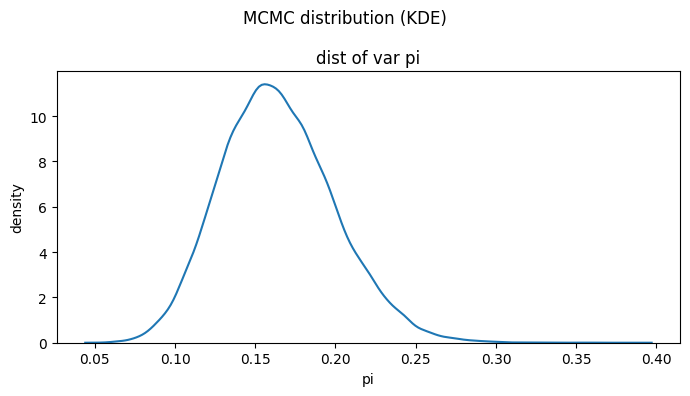

In [32]:
mcmc_dens(mcmc_results, individual_chains=False)

In [33]:
quantiles_mcmc(mcmc_results, "pi", [0.025, 0.975])

array([0.10114765, 0.23843563])

In [35]:
proba_mcmc(mcmc_results, "pi", between=[0.10114765, 0.23843563])

(None, 0.95, None)

In [36]:
mcmc_results_long = mcmc_combine_chains(mcmc_results)
mcmc_results_long

,sample_nr,var_name,is_warmup,chain,value
0,0,pi,False,chain_0,0.180474
1,1,pi,False,chain_0,0.172551
2,2,pi,False,chain_0,0.150554
3,3,pi,False,chain_0,0.150554
4,4,pi,False,chain_0,0.152793
...,...,...,...,...,...
39995,9995,pi,False,chain_3,0.179500
39996,9996,pi,False,chain_3,0.194791
39997,9997,pi,False,chain_3,0.153965
39998,9998,pi,False,chain_3,0.194295


In [37]:
mcmc_summarize(mcmc_results)

,n_samples,mean,mode,std,p2.5,p97.5
var_name,,,,,,
pi,40000,0.163959,0.155764,0.035267,0.064299,0.090863


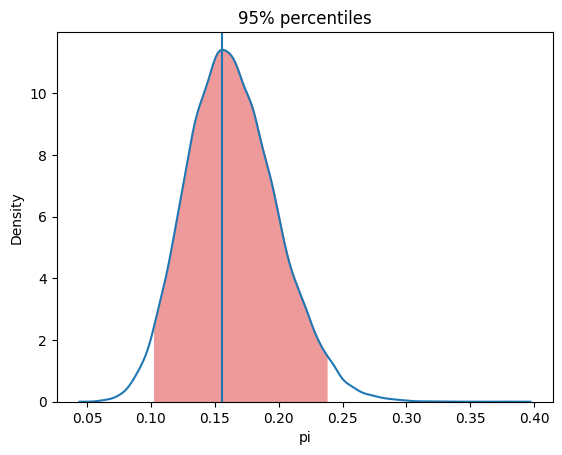

In [38]:
ax = sns.kdeplot(mcmc_results_long, x="value")
kde_x, kde_y = ax.lines[0].get_data()

x0, x1 = quantiles_mcmc(mcmc_results, "pi", [0.025, 0.975])

mode = mcmc_summarize(mcmc_results)["mode"].pi

ax.fill_between(kde_x, kde_y, where=(kde_x>=x0) & (kde_x<=x1), interpolate=False, color='#EF9A9A')
ax.axvline(mode)
plt.title("95% percentiles")
plt.xlabel("pi")
plt.show()

In [40]:
proba_mcmc(mcmc_results, "pi", l_than=0.2)

(0.847175, None, None)

## 8.4.3 Posterior prediction

Um das posterior predictive model zu erhalten, müssen wir zuerst die sampling variablility erzeugen. Dazu erstellen wir eine neue spalte, wobei wir mit bestimmten pi von der Binomialverteilung sampeln:

In [41]:
mcmc_results_long

,sample_nr,var_name,is_warmup,chain,value
0,0,pi,False,chain_0,0.180474
1,1,pi,False,chain_0,0.172551
2,2,pi,False,chain_0,0.150554
3,3,pi,False,chain_0,0.150554
4,4,pi,False,chain_0,0.152793
...,...,...,...,...,...
39995,9995,pi,False,chain_3,0.179500
39996,9996,pi,False,chain_3,0.194791
39997,9997,pi,False,chain_3,0.153965
39998,9998,pi,False,chain_3,0.194295


In [42]:
mcmc_results_long["y_predict"] = stats.binom(n=20, p=mcmc_results_long.value).rvs()

mcmc_results_long

,sample_nr,var_name,is_warmup,chain,value,y_predict
0,0,pi,False,chain_0,0.180474,3
1,1,pi,False,chain_0,0.172551,1
2,2,pi,False,chain_0,0.150554,2
3,3,pi,False,chain_0,0.150554,2
4,4,pi,False,chain_0,0.152793,3
...,...,...,...,...,...,...
39995,9995,pi,False,chain_3,0.179500,5
39996,9996,pi,False,chain_3,0.194791,4
39997,9997,pi,False,chain_3,0.153965,3
39998,9998,pi,False,chain_3,0.194295,5


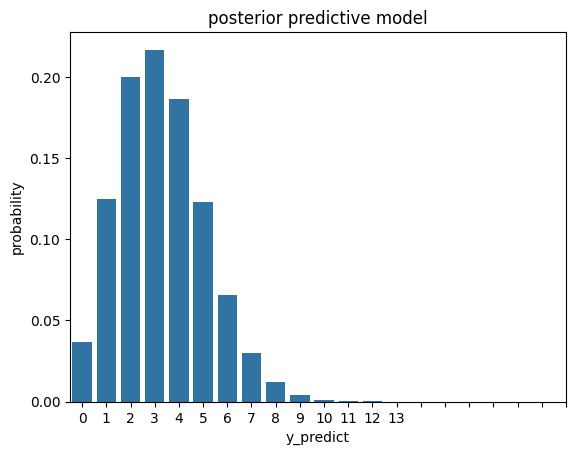

In [43]:
sns.countplot(mcmc_results_long, x="y_predict", stat="probability")
plt.xticks(np.arange(0, 21))
plt.title("posterior predictive model")
plt.show()

Zählen wir nun die Anzahl der verschiedenen $y'$ und teilen durch deren relative Häufigkeit, so erhalten wir die simulierte Wahrscheinlichkeit für jedes $\pi$ wenn wir 20 neue samples erhalten.